In [93]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

#Import preprocessing libraries
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import LabelEncoder


In [94]:
#Read Li-Small Dataset  
df = pd.read_csv("LI-Small_Trans.csv",header=0,parse_dates=[0])

In [95]:
#rename the target label
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [96]:
#Select columns of object type
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [97]:
# Use Label Encoding to quantify object type columns
label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])

# Sort by payment complexity
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use map method to encode Payment Format column
df['Payment Format'] = df['Payment Format'].map(payment_map)

df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
0,2022-09-01 00:08:00,11,950,11,900,3195403.00,12,3195403.00,12,7,0
1,2022-09-01 00:21:00,3402,2772,3402,2446,1858.96,12,1858.96,12,7,0
2,2022-09-01 00:00:00,11,950,1120,8407,592571.00,12,592571.00,12,2,0
3,2022-09-01 00:16:00,3814,9998,3814,8419,12.32,12,12.32,12,7,0
4,2022-09-01 00:00:00,20,10001,20,8422,2941.56,12,2941.56,12,7,0


In [98]:
# Separate labels from the dataset
labels = df['Is_Laundering']

#list of column to drop
columns_to_drop = ['Timestamp', 'Is_Laundering']
# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [99]:
#Normalize the data set
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)

# Convert the normalized data into a DataFrame object and set the column names
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)


# Add the label column to the regression-normalized data set
df_normalized['Is_Laundering'] = labels.tolist()

# Output the normalized data
print(df_normalized.head())

   From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.999942 -0.997211 -0.999942  -0.996876        -0.999998   
1  -0.981951 -0.991862 -0.981951  -0.991510        -1.000000   
2  -0.999942 -0.997211 -0.994058  -0.970818        -1.000000   
3  -0.979765 -0.970649 -0.979765  -0.970776        -1.000000   
4  -0.999894 -0.970641 -0.999894  -0.970766        -1.000000   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0            0.714286    -0.999998          0.714286        1.000000   
1            0.714286    -1.000000          0.714286        1.000000   
2            0.714286    -1.000000          0.714286       -0.666667   
3            0.714286    -1.000000          0.714286        1.000000   
4            0.714286    -1.000000          0.714286        1.000000   

   Is_Laundering  
0              0  
1              0  
2              0  
3              0  
4              0  


In [100]:
# Select rows with Is_Laundering column as 1
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]

# Output the selected data
print(df_normalized.count())
df_laundering.count()

From Bank             6924049
Account               6924049
To Bank               6924049
Account.1             6924049
Amount Received       6924049
Receiving Currency    6924049
Amount Paid           6924049
Payment Currency      6924049
Payment Format        6924049
Is_Laundering         6924049
dtype: int64


From Bank             3565
Account               3565
To Bank               3565
Account.1             3565
Amount Received       3565
Receiving Currency    3565
Amount Paid           3565
Payment Currency      3565
Payment Format        3565
Is_Laundering         3565
dtype: int64

In [101]:
# Shuffle the data before creating the subsamples since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

df_normalized = df_normalized.sample(frac=1)

fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
1892987,-0.881878,-0.897434,-0.202493,0.646534,-1.000000,-0.428571,-1.000000,-0.428571,-0.666667,0
6780218,-0.810185,-0.038481,-0.280796,-0.052399,-1.000000,-0.571429,-1.000000,-0.571429,-0.333333,1
3008939,-0.117329,0.754615,-0.998854,0.745532,-1.000000,0.142857,-1.000000,0.142857,-0.333333,1
1504803,-0.916263,-0.551923,-0.382052,-0.335133,-1.000000,0.714286,-1.000000,0.714286,0.000000,0
1425545,-0.999905,-0.704732,-0.843106,-0.457245,-0.999999,0.857143,-0.999999,0.857143,-0.666667,0


In [102]:
# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the data into training and temporary test sets (80% train, 20% temp test)
X_train, X_temp_test, y_train, y_temp_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary test set into validation and final test sets (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size=0.5, random_state=42)



K-MEANS PREDICT, FIT, CLUSTERING, ACCURACY

In [103]:
# Scale numerical features in training, validation, and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train K-means model on the training set
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)

# Predict cluster labels for the validation set
cluster_labels_val = kmeans.predict(X_val_scaled)

# Evaluate clustering performance on the validation set
accuracy_val = accuracy_score(y_val, cluster_labels_val)
print("KMeans has a validation score of", round(accuracy_val, 2) * 100, "% accuracy score")

# Optionally, predict cluster labels for the test set and evaluate performance
cluster_labels_test = kmeans.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, cluster_labels_test)
print("KMeans has a test score of", round(accuracy_test, 2) * 100, "% accuracy score")

c:\Users\Qistina\miniconda3\envs\practicecode\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans has a validation score of 45.0 % accuracy score
KMeans has a test score of 41.0 % accuracy score


Identify Anomalies

In [104]:
# Calculate distances from each point to its nearest cluster center
distances = kmeans.transform(X_train_scaled)

# Calculate the average distance for each point
average_distances = np.mean(distances, axis=1)

# Determine a threshold for anomaly detection (e.g., based on percentiles)
threshold = np.percentile(average_distances, 95)  # Adjust percentile as needed

# Identify anomalies based on the threshold
anomalies = X_train[average_distances > threshold]

# Print or visualize anomalies
print("Anomalies:")
print(anomalies)

Anomalies:
         From Bank   Account   To Bank  Account.1  Amount Received  \
254057    0.780288  0.557260  0.147092   0.546308         -1.00000   
646298    0.128242 -0.619519  0.128242  -0.627273         -1.00000   
2610918   0.432481  0.874046  0.432481   0.868207         -1.00000   
6139187   0.992158  0.968856 -0.626551   0.966847         -1.00000   
86957     0.705486 -0.006629  0.705486  -0.020811         -1.00000   
...            ...       ...       ...        ...              ...   
2986777  -0.999894  0.824278 -0.095104   0.867790         -1.00000   
2111054  -0.623580  0.872839  0.452711   0.968103         -1.00000   
261309    0.138317  0.760325  0.138317   0.751291         -1.00000   
1584130   0.863633  0.372003 -0.199824   0.358639         -1.00000   
316786    0.184618 -0.366953  0.184618  -0.378581         -0.99995   

         Receiving Currency  Amount Paid  Payment Currency  Payment Format  
254057            -0.428571     -1.00000         -0.428571       -0.333

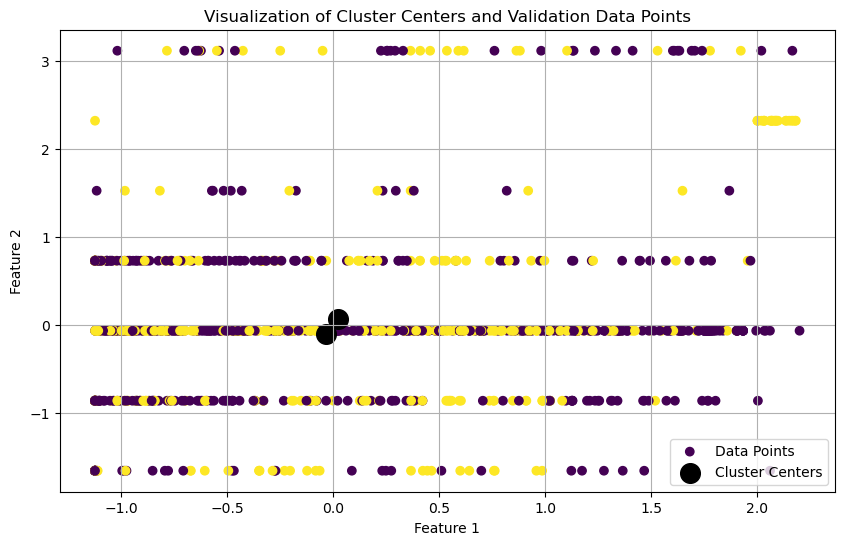

In [129]:
# Visualize clusters and cluster centers
plt.figure(figsize=(10, 6))

# Plot data points with cluster labels
plt.scatter(X_val_scaled[:, 1], X_val_scaled[:, 8], c=cluster_labels_val, cmap='viridis', label='Data Points')

# Plot cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='o', s=200, label='Cluster Centers')

plt.title('Visualization of Cluster Centers and Validation Data Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


We find the majority cluster by counting the occurrences of each cluster label and selecting the cluster with the highest count.
Anomalies are then identified as data points that do not belong to the majority cluster (i.e., points with cluster labels different from the majority cluster).
As below

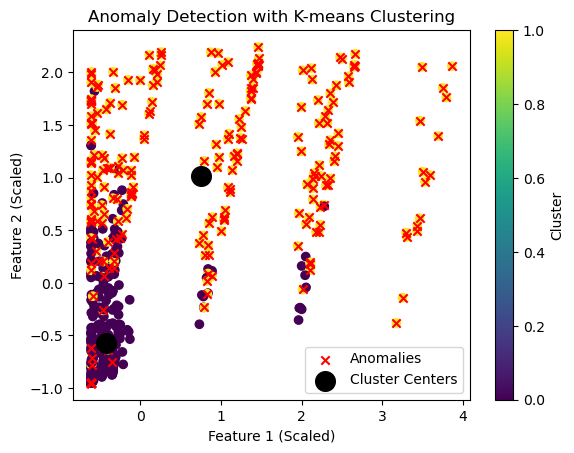

In [108]:
plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=cluster_labels_val, cmap='viridis')

# Plot anomalies (outliers)
outlier_cluster = np.argmax(np.bincount(cluster_labels_val))  # Find the cluster with the majority of points
anomalies = X_val_scaled[cluster_labels_val != outlier_cluster]
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', marker='x', label='Anomalies')
# Plot cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='o', s=200, label='Cluster Centers')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.title('Anomaly Detection with K-means Clustering')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


EVALUATE THE ANOMALIES
- The silhouette score measures how similar an object is to its own cluster (cohesion) compared to other clusters (separation). Higher silhouette scores indicate better clustering.
- The adjusted Rand index measures the similarity between two clusterings, where a score of 1.0 indicates perfect clustering agreement.

In [109]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Compute silhouette score
silhouette_score_val = silhouette_score(X_val_scaled, cluster_labels_val)
print("Silhouette Score:", silhouette_score_val)

# Compute adjusted Rand index
adjusted_rand_index_val = adjusted_rand_score(y_val, cluster_labels_val)
print("Adjusted Rand Index:", adjusted_rand_index_val)


Silhouette Score: 0.2746097361958232
Adjusted Rand Index: 0.00747638062454765


USING HI-SMALL DATA

In [110]:
#Read Li-Small Dataset  
df = pd.read_csv("HI-Small_Trans.csv",header=0,parse_dates=[0])

In [111]:
#rename the target label
df = df.rename(columns={'Is Laundering': 'Is_Laundering'})

In [112]:
#Select columns of object type
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols

['Account',
 'Account.1',
 'Receiving Currency',
 'Payment Currency',
 'Payment Format']

In [113]:
# Use Label Encoding to quantify object type columns
label_encoder = LabelEncoder()
for col in object_cols:
    if col != 'Payment Format':
        df[col] = label_encoder.fit_transform(df[col])

# Sort by payment complexity
payment_map = {'Cash': 1, 'Cheque': 2, 'ACH': 3, 'Credit Card': 4, 'Wire': 5, 'Bitcoin': 6, 'Reinvestment': 7}

# Use map method to encode Payment Format column
df['Payment Format'] = df['Payment Format'].map(payment_map)

df.head()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
0,2022-09-01 00:20:00,10,942,10,900,3697.34,12,3697.34,12,7,0
1,2022-09-01 00:20:00,3208,990,1,949,0.01,12,0.01,12,2,0
2,2022-09-01 00:00:00,3209,991,3209,940,14675.57,12,14675.57,12,7,0
3,2022-09-01 00:02:00,12,997,12,945,2806.97,12,2806.97,12,7,0
4,2022-09-01 00:06:00,10,999,10,947,36682.97,12,36682.97,12,7,0


In [114]:
# Separate labels from the dataset
labels = df['Is_Laundering']

#list of column to drop
columns_to_drop = ['Timestamp', 'Is_Laundering']
# Drop the specified columns
df.drop(columns=columns_to_drop, inplace=True)

In [115]:
#Normalize the data set
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(df)
df_normalized = scaler.transform(df)

# Convert the normalized data into a DataFrame object and set the column names
df_normalized = pd.DataFrame(df_normalized, columns=df.columns)


# Add the label column to the regression-normalized data set
df_normalized['Is_Laundering'] = labels.tolist()

# Output the normalized data
print(df_normalized.head())

   From Bank   Account   To Bank  Account.1  Amount Received  \
0  -0.999949 -0.996209 -0.999949  -0.995721             -1.0   
1  -0.981998 -0.996016 -1.000000  -0.995488             -1.0   
2  -0.981993 -0.996012 -0.981992  -0.995531             -1.0   
3  -0.999938 -0.995988 -0.999938  -0.995507             -1.0   
4  -0.999949 -0.995980 -0.999949  -0.995497             -1.0   

   Receiving Currency  Amount Paid  Payment Currency  Payment Format  \
0            0.714286         -1.0          0.714286        1.000000   
1            0.714286         -1.0          0.714286       -0.666667   
2            0.714286         -1.0          0.714286        1.000000   
3            0.714286         -1.0          0.714286        1.000000   
4            0.714286         -1.0          0.714286        1.000000   

   Is_Laundering  
0              0  
1              0  
2              0  
3              0  
4              0  


In [116]:
# Select rows with Is_Laundering column as 1
df_laundering = df_normalized.loc[df_normalized['Is_Laundering'] == 1]

# Output the selected data
print(df_normalized.count())
df_laundering.count()

From Bank             5078345
Account               5078345
To Bank               5078345
Account.1             5078345
Amount Received       5078345
Receiving Currency    5078345
Amount Paid           5078345
Payment Currency      5078345
Payment Format        5078345
Is_Laundering         5078345
dtype: int64


From Bank             5177
Account               5177
To Bank               5177
Account.1             5177
Amount Received       5177
Receiving Currency    5177
Amount Paid           5177
Payment Currency      5177
Payment Format        5177
Is_Laundering         5177
dtype: int64

In [117]:
# Shuffle the data before creating the subsamples since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

df_normalized = df_normalized.sample(frac=1)

fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 1]
non_fraud_df = df_normalized.loc[df_normalized['Is_Laundering'] == 0][:len(fraud_df)]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is_Laundering
4418910,-0.974617,-0.548626,-0.965450,-0.233934,-1.0,0.714286,-1.0,0.714286,0.000000,0
4136543,-0.999613,-0.999956,-0.999349,-0.996539,-1.0,0.428571,-1.0,0.428571,-0.666667,0
2012938,-0.981808,-0.823905,-0.926218,-0.829249,-1.0,0.714286,-1.0,0.714286,-0.333333,1
3863626,-0.866175,-0.837841,-0.982329,-0.875964,-1.0,0.714286,-1.0,0.714286,-0.333333,1
4213204,-0.999613,-0.999972,-0.294715,-0.071827,-1.0,-0.571429,-1.0,-0.571429,-1.000000,1


In [118]:
# Split the dataset into features and target variable
X = new_df.drop('Is_Laundering', axis=1)
y = new_df['Is_Laundering']

# Split the data into training and temporary test sets (80% train, 20% temp test)
X_train, X_temp_test, y_train, y_temp_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary test set into validation and final test sets (50% each)
X_val, X_test, y_val, y_test = train_test_split(X_temp_test, y_temp_test, test_size=0.5, random_state=42)



K-Means Prediction

In [119]:
# Scale numerical features in training, validation, and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Train K-means model on the training set
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_train_scaled)

# Predict cluster labels for the validation set
cluster_labels_val = kmeans.predict(X_val_scaled)

# Evaluate clustering performance on the validation set
accuracy_val = accuracy_score(y_val, cluster_labels_val)
print("KMeans has a validation score of", round(accuracy_val, 2) * 100, "% accuracy score")

# Optionally, predict cluster labels for the test set and evaluate performance
cluster_labels_test = kmeans.predict(X_test_scaled)
accuracy_test = accuracy_score(y_test, cluster_labels_test)
print("KMeans has a test score of", round(accuracy_test, 2) * 100, "% accuracy score")

c:\Users\Qistina\miniconda3\envs\practicecode\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans has a validation score of 51.0 % accuracy score
KMeans has a test score of 48.0 % accuracy score


In [120]:
# Calculate distances from each point to its nearest cluster center
distances = kmeans.transform(X_train_scaled)

# Calculate the average distance for each point
average_distances = np.mean(distances, axis=1)

# Determine a threshold for anomaly detection (e.g., based on percentiles)
threshold = np.percentile(average_distances, 95)  # Adjust percentile as needed

# Identify anomalies based on the threshold
anomalies = X_train[average_distances > threshold]

# Print or visualize anomalies
print("Anomalies:")
print(anomalies)

Anomalies:
         From Bank   Account   To Bank  Account.1  Amount Received  \
4166827   0.427744  0.944909 -0.136520   0.941503        -1.000000   
523887    0.222687 -0.308100  0.222718  -0.319938        -1.000000   
108241   -0.926826  0.773454 -0.926824   0.764266        -1.000000   
180599   -0.220712  0.548051 -0.220692   0.536876        -1.000000   
2224669  -0.143277  0.927154 -0.999921   0.922655        -1.000000   
...            ...       ...       ...        ...              ...   
3371532  -0.999298  0.892643 -0.999310   0.944693        -1.000000   
628372   -0.999613 -0.999944  0.427146   0.925527        -1.000000   
266035   -0.844211  0.009670 -0.844207  -0.004030        -0.999998   
94773    -0.294430  0.518457 -0.294412   0.507007        -1.000000   
3245837   0.182233  0.279488  0.411018   0.824370        -1.000000   

         Receiving Currency  Amount Paid  Payment Currency  Payment Format  
4166827           -0.857143    -1.000000         -0.857143        0.666

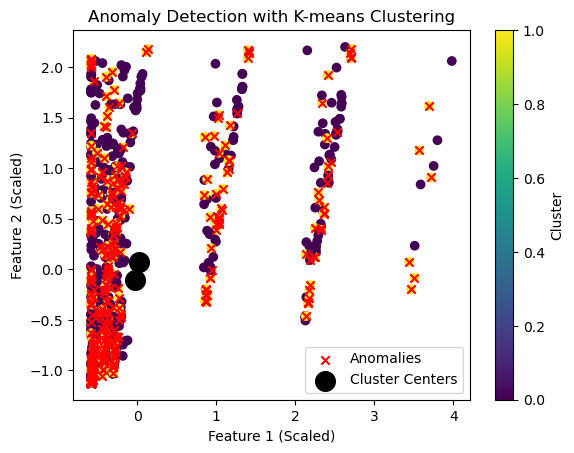

In [136]:
plt.scatter(X_val_scaled[:, 0], X_val_scaled[:, 1], c=cluster_labels_val, cmap='viridis')

# Plot anomalies (outliers)
outlier_cluster = np.argmax(np.bincount(cluster_labels_val))  # Find the cluster with the majority of points
anomalies = X_val_scaled[cluster_labels_val != outlier_cluster]
plt.scatter(anomalies[:, 0], anomalies[:, 1], c='red', marker='x', label='Anomalies')
# Plot cluster centers
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='o', s=200, label='Cluster Centers')
plt.xlabel('Feature 1 (Scaled)')
plt.ylabel('Feature 2 (Scaled)')
plt.title('Anomaly Detection with K-means Clustering')
plt.colorbar(label='Cluster')
plt.legend()
plt.show()


In [122]:
from sklearn.metrics import silhouette_score, adjusted_rand_score

# Compute silhouette score
silhouette_score_val = silhouette_score(X_val_scaled, cluster_labels_val)
print("Silhouette Score:", silhouette_score_val)

# Compute adjusted Rand index
adjusted_rand_index_val = adjusted_rand_score(y_val, cluster_labels_val)
print("Adjusted Rand Index:", adjusted_rand_index_val)


Silhouette Score: 0.27232936592503126
Adjusted Rand Index: -0.0004683749166767103
